In [ ]:
# default_exp experiments.utils

# Experiment Utils
> Set of functions to easily perform experiments.

In [ ]:
#export
ENV_VARS = dict(OMP_NUM_THREADS='2',
                OPENBLAS_NUM_THREADS='2',
                MKL_NUM_THREADS='3',
                VECLIB_MAXIMUM_THREADS='2',
                NUMEXPR_NUM_THREADS='3')

In [ ]:
# export
import os
# Limit number of threads in numpy and others to avoid throttling
os.environ.update(ENV_VARS)
import random
import time
from functools import partial

import numpy as np
import pandas as pd
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

from nixtla.data.scalers import Scaler
from nixtla.data.tsdataset import TimeSeriesDataset
from nixtla.data.tsloader import TimeSeriesLoader
from nixtla.models.esrnn.esrnn import ESRNN
from nixtla.models.esrnn.mqesrnn import MQESRNN
from nixtla.models.nbeats.nbeats_model import NBEATS

In [ ]:
# export
def get_mask_dfs(Y_df, ds_in_val, ds_in_test):
    # train mask
    train_mask_df = Y_df.copy()[['unique_id', 'ds']]
    train_mask_df.sort_values(by=['unique_id', 'ds'], inplace=True)
    train_mask_df.reset_index(drop=True, inplace=True)
    
    train_mask_df['sample_mask'] = 1
    train_mask_df['available_mask'] = 1
    
    idx_out = train_mask_df.groupby('unique_id').tail(ds_in_val+ds_in_test).index
    train_mask_df.loc[idx_out, 'sample_mask'] = 0
    
    # test mask
    test_mask_df = train_mask_df.copy()
    test_mask_df['sample_mask'] = 0
    idx_test = test_mask_df.groupby('unique_id').tail(ds_in_test).index
    test_mask_df.loc[idx_test, 'sample_mask'] = 1
    
    # validation mask
    val_mask_df = train_mask_df.copy()
    val_mask_df['sample_mask'] = 1
    val_mask_df['sample_mask'] = val_mask_df['sample_mask'] - train_mask_df['sample_mask']
    val_mask_df['sample_mask'] = val_mask_df['sample_mask'] - test_mask_df['sample_mask']

    assert len(train_mask_df)==len(Y_df), \
        f'The mask_df length {len(train_mask_df)} is not equal to Y_df length {len(Y_df)}'
    
    return train_mask_df, val_mask_df, test_mask_df

In [ ]:
# export
def get_random_mask_dfs(Y_df, ds_in_test, 
                        n_val_windows, n_ds_val_window,
                        n_uids, freq):
    """
    Generates train, test and random validation mask.
    Train mask begins by avoiding ds_in_test
    
    Validation mask: 1) samples n_uids unique ids
                     2) creates windows of size n_ds_val_window
    Parameters
    ----------
    ds_in_test: int
        Number of ds in test.
    n_uids: int
        Number of unique ids in validation.
    n_val_windows: int
        Number of windows for validation.
    n_ds_val_window: int
        Number of ds in each validation window.
    periods: int  
        ds_in_test multiplier.
    freq: str
        string that determines datestamp frequency, used in
        random windows creation.
    """
    np.random.seed(1)
    #----------------------- Train mask -----------------------#
    # Initialize masks
    train_mask_df, val_mask_df, test_mask_df = get_mask_dfs(Y_df=Y_df,
                                                            ds_in_val=0,
                                                            ds_in_test=ds_in_test)
    
    assert val_mask_df['sample_mask'].sum()==0, 'Muerte'
    
    #----------------- Random Validation mask -----------------#
    # Overwrite validation with random windows
    uids = train_mask_df['unique_id'].unique()
    val_uids = np.random.choice(uids, n_uids, replace=False)
    
    # Validation avoids test
    idx_test = train_mask_df.groupby('unique_id').tail(ds_in_test).index
    available_ds = train_mask_df.loc[~train_mask_df.index.isin(idx_test)]['ds'].unique()
    val_init_ds = np.random.choice(available_ds, n_val_windows, replace=False)
    
    # Creates windows 
    val_ds = [pd.date_range(init, periods=n_ds_val_window, freq=freq) for init in val_init_ds]
    val_ds = np.concatenate(val_ds)

    # Cleans random windows from train mask
    val_idx = train_mask_df.query('unique_id in @val_uids & ds in @val_ds').index
    train_mask_df.loc[val_idx, 'sample_mask'] = 0
    val_mask_df.loc[val_idx, 'sample_mask'] = 1
    
    return train_mask_df, val_mask_df, test_mask_df

In [ ]:
# export
def scale_data(Y_df, X_df, mask_df, normalizer_y, normalizer_x):
    mask = mask_df['available_mask'].values * mask_df['sample_mask'].values
    
    if normalizer_y is not None:
        scaler_y = Scaler(normalizer=normalizer_y)
        Y_df['y'] = scaler_y.scale(x=Y_df['y'].values, mask=mask)
    else:
        scaler_y = None

    if normalizer_x is not None:
        X_cols = [col for col in X_df.columns if col not in ['unique_id','ds']]
        for col in X_cols:
            scaler_x = Scaler(normalizer=normalizer_x)
            X_df[col] = scaler_x.scale(x=X_df[col].values, mask=mask)

    return Y_df, X_df, scaler_y

In [ ]:
# export
def create_datasets(mc, S_df, Y_df, X_df, f_cols,
                    ds_in_test, ds_in_val,
                    n_uids, n_val_windows, freq,
                    is_val_random):
    #------------------------------------- Available and Validation Mask ------------------------------------#
    if is_val_random:
        train_mask_df, val_mask_df, test_mask_df = get_random_mask_dfs(Y_df=Y_df, 
                                                                       ds_in_test=ds_in_test,
                                                                       n_uids=n_uids, 
                                                                       n_val_windows=n_val_windows, 
                                                                       n_ds_val_window=ds_in_val//n_val_windows,
                                                                       freq=freq)
    else:
        train_mask_df, val_mask_df, test_mask_df = get_mask_dfs(Y_df=Y_df,
                                                                ds_in_test=ds_in_test, 
                                                                ds_in_val=ds_in_val)

    #---------------------------------------------- Scale Data ----------------------------------------------#
    Y_df, X_df, scaler_y = scale_data(Y_df=Y_df, X_df=X_df, mask_df=train_mask_df,
                                      normalizer_y=mc['normalizer_y'], normalizer_x=mc['normalizer_x'])

    #----------------------------------------- Declare Dataset and Loaders ----------------------------------#
    train_dataset = TimeSeriesDataset(S_df=S_df, Y_df=Y_df, X_df=X_df, 
                                      mask_df=train_mask_df, f_cols=f_cols, 
                                      mode=mc['mode'],
                                      window_sampling_limit=int(mc['window_sampling_limit']),
                                      input_size=int(mc['input_size_multiplier']*mc['output_size']),
                                      output_size=int(mc['output_size']),
                                      idx_to_sample_freq=int(mc['idx_to_sample_freq']),
                                      len_sample_chunks=mc['len_sample_chunks'],
                                      complete_inputs=mc['complete_inputs'],
                                      verbose=True)
    val_dataset   = TimeSeriesDataset(S_df=S_df, Y_df=Y_df, X_df=X_df, 
                                      mask_df=val_mask_df, f_cols=f_cols, 
                                      mode=mc['mode'],
                                      window_sampling_limit=int(mc['window_sampling_limit']),
                                      input_size=int(mc['input_size_multiplier']*mc['output_size']),
                                      output_size=int(mc['output_size']),
                                      idx_to_sample_freq=int(mc['val_idx_to_sample_freq']),
                                      len_sample_chunks=mc['len_sample_chunks'],
                                      complete_inputs=mc['complete_inputs'],
                                      verbose=True)
    test_dataset  = TimeSeriesDataset(S_df=S_df, Y_df=Y_df, X_df=X_df, 
                                      mask_df=test_mask_df, f_cols=f_cols,
                                      mode=mc['mode'],
                                      window_sampling_limit=int(mc['window_sampling_limit']),
                                      input_size=int(mc['input_size_multiplier']*mc['output_size']),
                                      output_size=int(mc['output_size']),
                                      idx_to_sample_freq=mc['val_idx_to_sample_freq'],
                                      len_sample_chunks=mc['len_sample_chunks'],
                                      complete_inputs=False,
                                      verbose=True)
    
    if ds_in_test == 0:
        test_dataset = None

    return train_dataset, val_dataset, test_dataset, scaler_y

In [ ]:
# export
def instantiate_loaders(mc, train_dataset, val_dataset, test_dataset):
    train_loader = TimeSeriesLoader(dataset=train_dataset,
                                    batch_size=int(mc['batch_size']),
                                    shuffle=True)
    if val_dataset is not None:
        val_loader = TimeSeriesLoader(dataset=val_dataset,
                                      batch_size=1,
                                      shuffle=False)
        
    else:
        val_loader = None

    if test_dataset is not None:
        test_loader = TimeSeriesLoader(dataset=test_dataset,
                                       batch_size=1,
                                       shuffle=False)
    else:
        test_loader = None

    return train_loader, val_loader, test_loader

In [ ]:
# export
def instantiate_nbeats(mc):
    mc['n_hidden_list'] = len(mc['stack_types']) * [ mc['n_layers'][0]*[int(mc['n_hidden'])] ]
    model = NBEATS(n_time_in=int(mc['input_size_multiplier'] * mc['output_size']),
                   n_time_out=int(mc['output_size']),
                   n_x=int(mc['n_x']),
                   n_s=int(mc['n_s']),
                   n_s_hidden=int(mc['x_s_n_hidden']),
                   n_x_hidden=int(mc['exogenous_n_channels']),
                   shared_weights=mc['shared_weights'],
                   initialization=mc['initialization'],
                   activation=mc['activation'],
                   stack_types=mc['stack_types'],
                   n_blocks=mc['n_blocks'],
                   n_layers=mc['n_layers'],
                   n_theta_hidden=mc['n_hidden_list'],
                   n_harmonics=int(mc['n_harmonics']),
                   n_polynomials=int(mc['n_polynomials']),
                   batch_normalization = mc['batch_normalization'],
                   dropout_prob_theta=mc['dropout_prob_theta'],
                   learning_rate=float(mc['learning_rate']),
                   lr_decay=float(mc['lr_decay']),
                   n_lr_decay_steps=float(mc['n_lr_decay_steps']),
                   weight_decay=mc['weight_decay'],
                   n_iterations=int(mc['n_iterations']),
                   early_stopping=int(mc['early_stopping']),
                   loss=mc['loss'],
                   loss_hypar=float(mc['loss_hypar']),
                   val_loss=mc['val_loss'],
                   frequency=mc['frequency'],
                   seasonality=int(mc['seasonality']),
                   random_seed=int(mc['random_seed']))
    return model

In [ ]:
# export
def instantiate_esrnn(mc):    
    model = ESRNN(# Architecture parameters
                  input_size=int(mc['input_size_multiplier']*mc['output_size']),
                  output_size=int(mc['output_size']),
                  es_component=mc['es_component'],
                  cell_type=mc['cell_type'],
                  state_hsize=int(mc['state_hsize']),
                  dilations=mc['dilations'],
                  add_nl_layer=mc['add_nl_layer'],
                  # Optimization parameters
                  n_iterations=int(mc['n_iterations']),
                  early_stopping=int(mc['early_stopping']),                  
                  learning_rate=mc['learning_rate'],
                  lr_scheduler_step_size=int(mc['lr_scheduler_step_size']),
                  lr_decay=mc['lr_decay'],
                  per_series_lr_multip=mc['per_series_lr_multip'],
                  gradient_eps=mc['gradient_eps'],
                  gradient_clipping_threshold=mc['gradient_clipping_threshold'],
                  rnn_weight_decay=mc['rnn_weight_decay'],
                  noise_std=mc['noise_std'],
                  level_variability_penalty=mc['level_variability_penalty'],
                  testing_percentile=mc['testing_percentile'],
                  training_percentile=mc['training_percentile'],
                  loss=mc['loss'],
                  val_loss=mc['val_loss'],
                  seasonality=mc['seasonality'],
                  random_seed=int(mc['random_seed'])
                  # Data parameters
                  ) 
    return model

In [ ]:
# export
def instantiate_mqesrnn(mc):    
    model = MQESRNN(# Architecture parameters
                    input_size=int(mc['input_size_multiplier']*mc['output_size']),
                    output_size=int(mc['output_size']),
                    es_component=mc['es_component'],
                    cell_type=mc['cell_type'],
                    state_hsize=int(mc['state_hsize']),
                    dilations=mc['dilations'],
                    add_nl_layer=mc['add_nl_layer'],
                    # Optimization parameters
                    n_iterations=int(mc['n_iterations']),
                    early_stopping=int(mc['early_stopping']),                  
                    learning_rate=mc['learning_rate'],
                    lr_scheduler_step_size=int(mc['lr_scheduler_step_size']),
                    lr_decay=mc['lr_decay'],
                    gradient_eps=mc['gradient_eps'],
                    gradient_clipping_threshold=mc['gradient_clipping_threshold'],
                    rnn_weight_decay=mc['rnn_weight_decay'],
                    noise_std=mc['noise_std'],
                    testing_percentiles=list(mc['testing_percentiles']),
                    training_percentiles=list(mc['training_percentiles']),
                    loss=mc['loss'],
                    val_loss=mc['val_loss'],
                    random_seed=int(mc['random_seed'])
                    # Data parameters
                  ) 
    return model

In [ ]:
# export
def instantiate_model(mc):
    MODEL_DICT = {'nbeats': instantiate_nbeats,
                  'esrnn': instantiate_esrnn,
                  'mqesrnn': instantiate_mqesrnn,}
    return MODEL_DICT[mc['model']](mc)

In [ ]:
# export
def model_fit_predict(mc, S_df, Y_df, X_df, f_cols,
                      ds_in_test, ds_in_val,
                      n_uids, n_val_windows, freq,
                      is_val_random):
    
    # Protect inplace modifications
    Y_df = Y_df.copy()
    if X_df is not None:
        X_df = X_df.copy()
    if S_df is not None:
        S_df = S_df.copy()        

    #----------------------------------------------- Datasets -----------------------------------------------#
    train_dataset, val_dataset, test_dataset, scaler_y = create_datasets(mc=mc,
                                                                         S_df=S_df, Y_df=Y_df, X_df=X_df,
                                                                         f_cols=f_cols,
                                                                         ds_in_test=ds_in_test,
                                                                         ds_in_val=ds_in_val,
                                                                         n_uids=n_uids, 
                                                                         n_val_windows=n_val_windows,
                                                                         freq=freq, is_val_random=is_val_random)
    mc['n_x'], mc['n_s'] = train_dataset.get_n_variables()

    #------------------------------------------- Instantiate & fit -------------------------------------------#
    train_loader, val_loader, test_loader = instantiate_loaders(mc=mc,
                                                                train_dataset=train_dataset,
                                                                val_dataset=val_dataset,
                                                                test_dataset=test_dataset)
    model = instantiate_model(mc=mc)    
    model.fit(train_ts_loader=train_loader, val_ts_loader=val_loader, verbose=True, eval_freq=mc['eval_freq'])

    #------------------------------------------------ Predict ------------------------------------------------#
    # Predict test if available
    if ds_in_test > 0:
        y_true, y_hat, mask = model.predict(ts_loader=test_loader, return_decomposition=False)
        meta_data = test_loader.dataset.meta_data
    else:
        y_true, y_hat, mask = model.predict(ts_loader=val_loader, return_decomposition=False)
        meta_data = val_loader.dataset.meta_data
    
    # Scale to original scale
    if mc['normalizer_y'] is not None:
        y_true_shape = y_true.shape
        y_true = scaler_y.inv_scale(x=y_true.flatten())
        y_true = np.reshape(y_true, y_true_shape)

        y_hat = scaler_y.inv_scale(x=y_hat.flatten())
        y_hat = np.reshape(y_hat, y_true_shape)

    print(f"y_true.shape (#n_series, #n_fcds, #lt): {y_true.shape}")
    print(f"y_hat.shape (#n_series, #n_fcds, #lt): {y_hat.shape}")
    print("\n")
    return y_true, y_hat, mask, meta_data, model

In [ ]:
# export
def evaluate_model(mc, loss_function, 
                   S_df, Y_df, X_df, f_cols,
                   ds_in_test, ds_in_val,
                   n_uids, n_val_windows, freq,
                   is_val_random,
                   loss_kwargs):
    
    print(47*'=' + '\n')
    print(pd.Series(mc))
    print(47*'=' + '\n')
    
    # Some asserts due to work in progress
    n_series = Y_df['unique_id'].nunique()
    if n_series > 1:
        assert mc['normalizer_y'] is None, 'Data scaling not implemented with multiple time series'
        assert mc['normalizer_x'] is None, 'Data scaling not implemented with multiple time series'

    assert ds_in_test % mc['val_idx_to_sample_freq']==0, 'outsample size should be multiple of val_idx_to_sample_freq'

    # Make predictions
    start = time.time()
    y_true, y_hat, mask, meta_data, model = model_fit_predict(mc=mc,
                                                              S_df=S_df, 
                                                              Y_df=Y_df,
                                                              X_df=X_df,
                                                              f_cols=f_cols,
                                                              ds_in_test=ds_in_test, 
                                                              ds_in_val=ds_in_val,
                                                              n_uids=n_uids,
                                                              n_val_windows=n_val_windows,
                                                              freq=freq,
                                                              is_val_random=is_val_random)
    run_time = time.time() - start

    # Evaluate predictions
    loss = loss_function(y=y_true, y_hat=y_hat, weights=mask, **loss_kwargs)

    result =  {'loss': loss,
               'mc': mc,
               'y_true': y_true,
               'y_hat': y_hat,
               'trajectories': model.trajectories,
               'run_time': run_time,
               'status': STATUS_OK}
    return result

In [ ]:
# export
def hyperopt_tunning(space, hyperopt_max_evals, loss_function,
                     S_df, Y_df, X_df, f_cols,
                     ds_in_val,
                     n_uids, n_val_windows, freq,
                     is_val_random,
                     save_trials=False,
                     loss_kwargs=None):
    trials = Trials()
    fmin_objective = partial(evaluate_model, loss_function=loss_function, 
                             S_df=S_df, Y_df=Y_df, X_df=X_df, f_cols=f_cols,
                             ds_in_test=0, ds_in_val=ds_in_val,
                             n_uids=n_uids, n_val_windows=n_val_windows, freq=freq,
                             is_val_random=is_val_random,
                             loss_kwargs=loss_kwargs or {})

    fmin(fmin_objective, space=space, algo=tpe.suggest, max_evals=hyperopt_max_evals, trials=trials, verbose=True)

    return trials

# Experiment Utils Examples

In [ ]:
import torch as t
from nixtla.losses.numpy import mae, mape, smape, rmse, pinball_loss

In [ ]:
device = 'cpu'
if t.cuda.is_available(): device = 'cuda'  

nbeats_space= {# Architecture parameters
               'model':'nbeats',
               'mode': 'simple',
               'input_size_multiplier': hp.choice('input_size_multiplier', [7]),
               'output_size': hp.choice('output_size', [24]),
               'shared_weights': hp.choice('shared_weights', [False]),
               'activation': hp.choice('activation', ['SELU']),
               'initialization':  hp.choice('initialization', ['glorot_normal','he_normal']),
               'stack_types': hp.choice('stack_types', [2*['identity'],
                                                        1*['identity']+1*['exogenous_tcn'],
                                                        1*['exogenous_tcn']+1*['identity'] ]),
               'n_blocks': hp.choice('n_blocks', [ [1, 1] ]),
               'n_layers': hp.choice('n_layers', [ [2, 2] ]),
               'n_hidden': hp.choice('n_hidden', [ 364 ]),
               'n_harmonics': hp.choice('n_harmonics', [1]),
               'n_polynomials': hp.choice('n_polynomials', [2]),
               'exogenous_n_channels': hp.quniform('exogenous_n_channels', 1, 10, 1),
               'x_s_n_hidden': hp.choice('x_s_n_hidden', [0]),
               # Regularization and optimization parameters
               'batch_normalization': hp.choice('batch_normalization', [False]),
               'dropout_prob_theta': hp.uniform('dropout_prob_theta', 0, 0.5),
               'learning_rate': hp.loguniform('learning_rate', np.log(5e-4), np.log(0.001)),
               'lr_decay': hp.uniform('lr_decay', 0.3, 0.5),
               'n_lr_decay_steps': hp.choice('n_lr_decay_steps', [3]),
               'weight_decay': hp.loguniform('weight_decay', np.log(5e-5), np.log(5e-3)),
               'n_iterations': hp.choice('n_iterations', [10]), #[args.max_epochs]),
               'early_stopping': hp.choice('early_stopping', [16]),
               'eval_freq': hp.choice('eval_freq', [50]),
               'n_val_weeks': hp.choice('n_val_weeks', [52*2]),
               'loss': hp.choice('loss', ['MAE']),
               'loss_hypar': hp.choice('loss_hypar', [0.5]),                
               'val_loss': hp.choice('val_loss', ['MAE']), #[args.val_loss]),
               'l1_theta': hp.choice('l1_theta', [0]),
               # Data parameters
               'len_sample_chunks': hp.choice('len_sample_chunks', [None]),
               'normalizer_y': hp.choice('normalizer_y', [None]),
               'normalizer_x': hp.choice('normalizer_x', ['median']),
               'window_sampling_limit': hp.choice('window_sampling_limit', [100_000]),
               'complete_inputs': hp.choice('complete_inputs', [False]),
               'complete_sample': hp.choice('complete_sample', [False]),                
               'frequency': hp.choice('frequency', ['H']),
               'seasonality': hp.choice('seasonality', [24]),      
               'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [24]),
               'val_idx_to_sample_freq': hp.choice('val_idx_to_sample_freq', [24]),
               'batch_size': hp.choice('batch_size', [256]),
               'n_series_per_batch': hp.choice('n_series_per_batch', [1]),
               'random_seed': hp.quniform('random_seed', 10, 20, 1),
               'device': hp.choice('device', [device])}

mc = {'model':'nbeats',
      # Architecture parameters
      'input_size_multiplier': 7,
      'output_size': 24,
      'shared_weights': False,
      'activation': 'selu',
      'initialization': 'he_normal',
      'stack_types': ['exogenous_tcn']+1*['identity'],
      'n_blocks': [1, 1],
      'n_layers': [2, 2],
      'n_hidden': 364,
      'n_polynomials': 2,
      'n_harmonics': 1,
      'exogenous_n_channels': 3,
      'x_s_n_hidden': 0,
      # Regularization and optimization parameters
      'batch_normalization': False,
      'dropout_prob_theta': 0.2,
      'learning_rate': 0.0005, #0.002,
      'lr_decay': 0.64,
      'n_lr_decay_steps': 3,
      'weight_decay': 0.00015,
      'n_iterations': 100,
      'early_stopping': 8,
      'eval_freq': 50,
      'n_val_weeks': 52*2,
      'loss': 'PINBALL',
      'loss_hypar': 0.5, #0.49,
      'val_loss': 'MAE',
      'l1_theta': 0,
      # Data parameters
      'normalizer_y': None,
      'normalizer_x': 'median',
      'window_sampling_limit': 100_000,
      'complete_inputs': False,
      'frequency':'H',
      'seasonality': 24,
      'idx_to_sample_freq': 24,
      'val_idx_to_sample_freq': 24,
      'batch_size': 256,
      'n_series_per_batch': 1,
      'random_seed': 10,
      'device': 'cpu'}

In [ ]:
esrnn_space = {'model': hp.choice('model', ['esrnn']),
               'mode': 'full',
               # Architecture parameters
               'input_size_multiplier': hp.choice('input_size_multiplier', [7]),
               'output_size': hp.choice('output_size', [24]),
               'dilations': hp.choice('dilations', [ [[1, 2]], [[1,2], [7, 14]] ]),
               'es_component': hp.choice('es_component', ['multiplicative']),
               'cell_type': hp.choice('cell_type', ['LSTM']),
               'state_hsize': hp.quniform('state_hsize', 10, 100, 10),
               'add_nl_layer': hp.choice('add_nl_layer', [True, False]),
               'seasonality': hp.choice('seasonality', [ [24] ]),
               # Regularization and optimization parameters
               'n_iterations':hp.choice('n_iterations', [10]),
               'early_stopping':hp.choice('early_stopping', [10]),
               'eval_freq': hp.choice('eval_freq', [10]),
               'batch_size': hp.choice('batch_size', [32]),
               'learning_rate': hp.loguniform('learning_rate', np.log(5e-4), np.log(0.01)),
               'lr_scheduler_step_size': hp.choice('lr_scheduler_step_size', [100]),
               'lr_decay': hp.quniform('lr_decay', 0.5, 0.8, 0.1),
               'per_series_lr_multip': hp.choice('per_series_lr_multip', [0.5, 1.0, 1.5, 2.0, 3.0]),
               'gradient_eps': hp.choice('gradient_eps', [1e-8]),
               'gradient_clipping_threshold': hp.choice('gradient_clipping_threshold', [10, 50]),
               'rnn_weight_decay': hp.choice('rnn_weight_decay', [0, 0.0005, 0.005]),
               'noise_std': hp.loguniform('noise_std', np.log(0.0001), np.log(0.001)),
               'level_variability_penalty': hp.quniform('level_variability_penalty', 0, 100, 10),
               'testing_percentile': hp.choice('testing_percentile', [50]),
               'training_percentile': hp.choice('training_percentile', [48, 49, 50, 51]),
               'random_seed': hp.quniform('random_seed', 1, 1000, 1),
               'loss': hp.choice('loss', ['SMYL']),
               'val_loss': hp.choice('val_loss', ['MAE']),
               # Data parameters
               'len_sample_chunks': hp.choice('len_sample_chunks', [7*3*24]),
               'window_sampling_limit': hp.choice('window_sampling_limit', [500_000]),
               'complete_inputs': hp.choice('complete_inputs', [True]),
               'complete_sample': hp.choice('complete_sample', [True]),
               'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [24]),
               'val_idx_to_sample_freq': hp.choice('val_idx_to_sample_freq', [24]),
               'n_series_per_batch': hp.choice('n_series_per_batch', [1]),
               'normalizer_y': hp.choice('normalizer_y', [None]),
               'normalizer_x': hp.choice('normalizer_x',  [None])}

mc = {'model':'esrnn',
      'mode': 'full',
      # Architecture parameters
      'input_size_multiplier': 7,
      'output_size': 24,
      'dilations': [[1,2], [7]],
      'es_component': 'multiplicative',
      'cell_type': 'LSTM',
      'state_hsize': 50,
      'add_nl_layer': False,
      'seasonality': [24],
      # Regularization and optimization parameters
      'n_iterations': 10,#00,
      'early_stopping': 10,
      'eval_freq': 10,
      'batch_size': 32,
      'learning_rate': 0.0005,
      'lr_scheduler_step_size': 100,
      'lr_decay': 0.8,
      'per_series_lr_multip': 1.5,
      'gradient_eps': 1e-8, 
      'gradient_clipping_threshold': 20,
      'rnn_weight_decay': 0.0,
      'noise_std': 0.0005,
      'level_variability_penalty': 10,
      'testing_percentile': 50,
      'training_percentile': 50,
      'random_seed': 1,
      'loss': 'SMYL',
      'val_loss': 'MAE',
      # Data parameters
      'len_sample_chunks': 7*4*24,
      'window_sampling_limit': 500_000,
      'complete_inputs': True,
      'idx_to_sample_freq': 24,
      'val_idx_to_sample_freq': 24,
      'n_series_per_batch': 1,
      'normalizer_y': None,
      'normalizer_x': None}

In [ ]:
# model = instantiate_esrnn(mc)

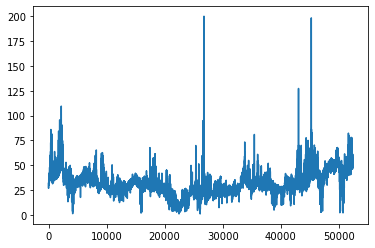

In [ ]:
from nixtla.data.datasets.epf import EPF, EPFInfo
import matplotlib.pyplot as plt

dataset = ['NP']

Y_df, X_df, S_df = EPF.load_groups(directory='data', groups=dataset)

X_df = X_df[['unique_id', 'ds', 'week_day']]
Y_min = Y_df.y.min()
#Y_df.y = Y_df.y - Y_min + 20

plt.plot(Y_df.y.values)
plt.show()

In [ ]:
# result = evaluate_model(loss_function=mae, mc=mc, 
#                         S_df=S_df, Y_df=Y_df, X_df=X_df, f_cols=[],
#                         ds_in_test=0, ds_in_val=728*24,
#                         n_uids=None, n_val_windows=None, freq=None,
#                         is_val_random=False, loss_kwargs={})
# result

In [ ]:
# plt.plot(result['y_hat'].flatten())
# plt.plot(Y_df['y'][-728*24:].values)

In [ ]:
# trials = hyperopt_tunning(space=nbeats_space, hyperopt_max_evals=2, loss_function=mae,
#                           S_df=S_df, Y_df=Y_df, X_df=X_df, f_cols=[],
#                           ds_in_val=728*24, n_uids=None, n_val_windows=None, freq=None,
#                           is_val_random=False, loss_kwargs={})

In [ ]:
# trials.trials